This notebook recreates  Figs. 18 and 19 in Merdith et al. (2017) 'A full-plate global reconstruction of the Neoproterozoic'. 

It calculates the RMS velocity of different continent polygons (NOT plates) through time.  The plot is a little messy, in the publication I manually separated the plateIDs into different groupings, which I haven't done here (sorry).  We finish with a plot of average RMS taking into account area.  The calculation uses a regularly spaced mesh on a sphere and abscribes a velocity to each node inside a polygon (hence area sensitive).

It should be (reasonably) adaptable for all times, provided you have a plate model.

In [87]:
import pygplates
import numpy as np
import healpy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.cm as cm
%matplotlib inline

In [88]:
def create_gpml_velocity_feature(longitude_array,latitude_array,filename=None,feature_type=None):
#function to make a velocity mesh nodes at an arbitrary set of points
#Long and Lat are assumed to be 1d arrays. 

    multi_point = pygplates.MultiPointOnSphere(zip(latitude_array,longitude_array))

    #Create a feature containing the multipoint feature. 
    #optionally, define as 'MeshNode' type, so that GPlates will recognise it as a velocity layer
    if feature_type=='MeshNode':
        meshnode_feature = pygplates.Feature(pygplates.FeatureType.create_from_qualified_string('gpml:MeshNode'))
        meshnode_feature.set_name('Velocity Mesh Nodes')
    else:
        meshnode_feature = pygplates.Feature()
        meshnode_feature.set_name('Multipoint Feature')
    
    meshnode_feature.set_geometry(multi_point)
    
    output_feature_collection = pygplates.FeatureCollection(meshnode_feature)
    
    if filename is not None:
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

def create_gpml_healpix_mesh(nSide,filename=None,feature_type=None):

    #call the function to create a healpix array
    #nSide = 32
    othetas,ophis = healpy.pix2ang(nSide,np.arange(12*nSide**2))
    othetas = np.pi/2-othetas
    ophis[ophis>np.pi] -= np.pi*2

    lats = np.degrees(othetas) 
    lons = np.degrees(ophis)

    #call the function to create a multipoint feature, with user-defined type
    output_feature_collection = create_gpml_velocity_feature(lons,lats,filename,feature_type)

    if filename is not None:  # This is superfluous, since file has already been written in previous line???
        output_feature_collection.write(filename)
    else:
        return output_feature_collection

In [89]:
#setbasedir for loading reconstruction files
basedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2017_GR/Sample_data/'

#Merdith (Mer17) model
Mer17_rotation_model = pygplates.RotationModel('%sMer17_1000-520Ma_rotations.rot' % basedir)
Mer17_polygons = pygplates.FeatureCollection('%sMer17_1000-520Ma_shapes.gpml' % basedir)

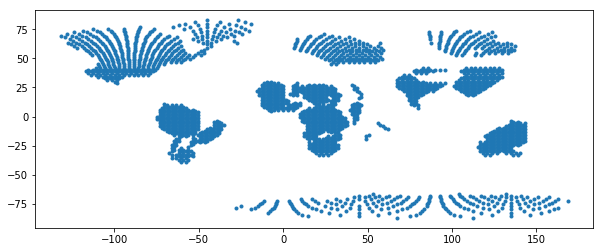

In [90]:
plate_ID_list = []
for polygon in Mer17_polygons:
    plate_ID_list.append(polygon.get_reconstruction_plate_id())
#remove duplicates
plate_ID_for_RMS = list(set(plate_ID_list))

selected_polygons = []

#iterate over every feature in the coastline file, and append the features that match our criteria
for polygon in Mer17_polygons:
    if polygon.get_reconstruction_plate_id() in plate_ID_for_RMS:
        selected_polygons.append(polygon)
        
latlon_mesh = create_gpml_healpix_mesh(32)

#partition features
partitioned_points = pygplates.partition_into_plates(selected_polygons,
                                                       Mer17_rotation_model,
                                                       latlon_mesh)

#get only the multipoint features that fall within the selected polygon(s)
#these multipoints are what we calculate the velocity with
features_within_selected_plate = []
for point in partitioned_points:
    if point.get_reconstruction_plate_id() in plate_ID_for_RMS:
        features_within_selected_plate.append(point)

lon = []
lat = []

#now get the lats and lons of these points, we don't actually need them
#for the analysis, but it's good to check the above code works
for feature in features_within_selected_plate:
    for geometry in feature.get_geometries():
        lat.append(geometry.to_lat_lon_array()[:,0])
        lon.append(geometry.to_lat_lon_array()[:,1])
    
lon = np.concatenate(lon)
lat = np.concatenate(lat)

#quick and dirty plot to show we have something reasonable
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.plot(lon[:],lat[:],'.')
#parfait

In [92]:
#coooool now to do it through time

plate_ID = plate_ID_for_RMS
delta_time = 1. #for the stage pole, we calculate backwards in time
RMS_list = []

for feature, plate in zip(features_within_selected_plate,plate_ID):
    tmp1 = []
    for time in np.arange(520,1001,1): 
        #print time
        velocity_magnitude=[]
        #Reconstruct the point features.
        reconstructed_feature_geometries = []
        pygplates.reconstruct(feature, Mer17_rotation_model, reconstructed_feature_geometries, time)

       #Get the rotation from 'time+delta' to 'time', and the feature's reconstruction plate ID
        equivalent_stage_rotation = Mer17_rotation_model.get_rotation(time,
                                                                plate,
                                                                time + delta_time)
        #Calculate a velocity for each reconstructed point over the delta time interval
        for reconstructed_feature_geometry in reconstructed_feature_geometries:      
            velocity_vector = pygplates.calculate_velocities(
                reconstructed_feature_geometry.get_reconstructed_geometry(),
                equivalent_stage_rotation,
                delta_time,
                pygplates.VelocityUnits.cms_per_yr)

            #get the mangnitude (it's a bit of a mouthful :/)
            velocity_magnitude_azimuth = pygplates.LocalCartesian.convert_from_geocentric_to_magnitude_azimuth_inclination(
                                    reconstructed_feature_geometry.get_reconstructed_geometry(),
                                    velocity_vector)

            #we just want the first puppy
            velocity_magnitude.append(velocity_magnitude_azimuth[0])

        #'turn' into root-mean-squared velocity
        RMS_velocity_for_stage = np.sqrt(np.mean(np.square(np.asarray(velocity_magnitude))))
        tmp1.append(RMS_velocity_for_stage)

    RMS_list.append(tmp1)

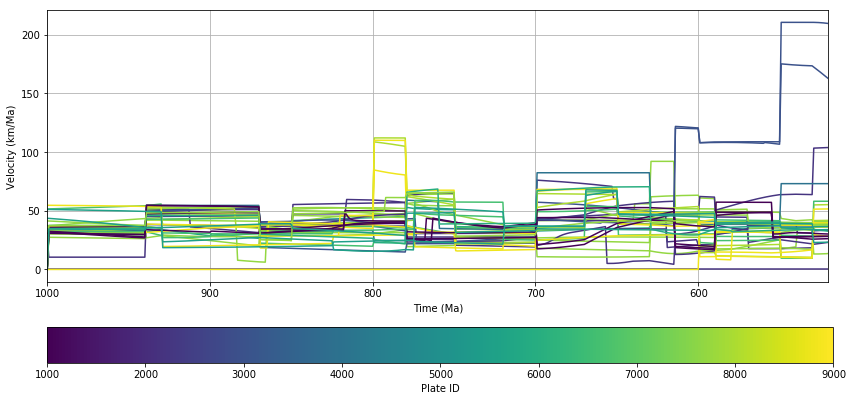

In [138]:
#the resulting plot is pretty messy though, we could specify individual plate IDs to make it tidier
times = np.arange(520,1001,1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))

cm = plt.get_cmap('viridis')#more colobar madness
#normalise it to range between the min and max plateIDs, but we will round them to the nearest 1000 so it's a
#*bit* nicer
norm=mpl.colors.Normalize(vmin=np.round(min(plate_ID_for_RMS), decimals=-3),
                          vmax=np.round(max(plate_ID_for_RMS), decimals=-3))
#create a mappable colourbar between vmin and vmax
#since plateIDs aren't continuous, there is likely to be some clumping at some areas
m = plt.cm.ScalarMappable(norm=norm, cmap=cm)


for x,y in zip(RMS_list,plate_ID_for_RMS):
    color = m.to_rgba(y)
    #multiply by 10 for mm/a or km/Ma
    plot = plt.plot(times,[z*10 for z in x],c=color)
ax.set_xlim(1000,520)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Velocity (km/Ma)')
ax.grid()
#colourbar :*(
cbax = fig.add_axes([0.125, -0.10, .78, 0.1])
cb = mpl.colorbar.ColorbarBase(cbax, cmap=cm, norm=norm, orientation='horizontal')   
cb.set_label('Plate ID')
plt.show()

In [139]:
#now for mean RMS
#as each point occupies the same area on a sphere, we have already normalised for area
#(because smaller polygons will have fewer points inside them)

#compute average at each time slice
RMS_mean = np.average(np.asarray(RMS_list), axis=0)

#we also want to plot the overall average for rerence
RMS_mean_overall = np.zeros(np.shape(RMS_mean)) #create dummy array of same size to plot overall average
RMS_mean_overall.fill(np.average(RMS_np_ave)) #fill with the mean, which is ~3.7 cm/a

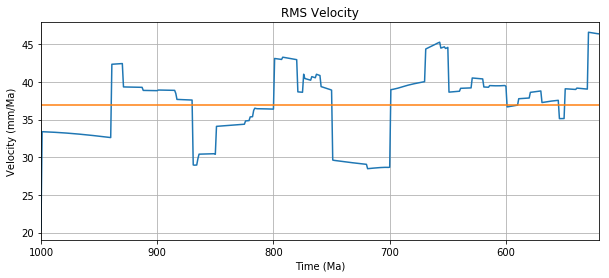

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
ax.set_xlim(1000,520)
ax.plot(times,RMS_mean*10)
ax.plot(times,RMS_mean_overall*10)
ax.set_xlabel('Time (Ma)')
ax.set_ylabel('Velocity (mm/Ma)')
ax.set_title('RMS Velocity')
ax.grid()